# Robust Mean–Variance Optimization with Rolling Backtest

**Goal.** Construct a long-only, regularized mean–variance portfolio with turnover control and evaluate it out-of-sample with monthly rebalancing and transaction costs.

**Key choices**
- Expected returns: mean of trailing window
- Risk model: Ledoit–Wolf shrinkage covariance
- Regularization: L2 (ridge); optional L1 for sparsity
- Constraints: sum(w)=1, 0 ≤ w ≤ w_max
- Turnover penalty: discourages large month-to-month changes
- Rebalance: monthly (last business day)
- Costs: proportional (bps per one-way trade)


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path
import cvxpy as cp

from pandas.tseries.offsets import BMonthEnd
plt.rcParams["figure.figsize"] = (9, 5)

DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
FIG_DIR  = Path("figs"); FIG_DIR.mkdir(exist_ok=True)


In [2]:
tickers = ["AAPL","MSFT","NVDA","AMZN","JPM","TSLA","XOM","PG"]  # tech + bank + energy + staples
start = "2014-01-01"
end   = None  # up to latest

px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
px = px.dropna(how="all").ffill()  # forward-fill occasional gaps
px.tail()


Ticker,AAPL,AMZN,JPM,MSFT,NVDA,PG,TSLA,XOM
Date,,,,,,,,
2025-08-18,230.889999,231.490005,291.529999,516.251282,182.009995,155.720001,335.160004,106.720001
2025-08-19,230.559998,228.009995,290.660004,508.933350,175.639999,158.399994,329.309998,107.419998
2025-08-20,226.009995,223.809998,292.239990,504.890015,175.399994,159.509995,323.899994,108.529999
2025-08-21,224.899994,221.949997,291.470001,504.239990,174.979996,158.729996,320.109985,109.230003
2025-08-22,227.759995,228.839996,296.239990,507.230011,177.990005,158.669998,340.010010,111.279999


In [3]:
# Rebalance on month-end; use month-end prices
px_m = px.resample("M").last()

# Simple monthly returns; log returns also fine
ret_m = px_m.pct_change().dropna()

# Sanity
ret_m.describe().T.head()


C:\Users\tqtoa\AppData\Local\Temp\ipykernel_23712\3775159055.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  px_m = px.resample("M").last()


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,139.0,0.022423,0.077178,-0.181198,-0.032977,0.025872,0.077531,0.216569
AMZN,139.0,0.022186,0.087399,-0.237525,-0.036028,0.023475,0.074850,0.270596
JPM,139.0,0.016740,0.068439,-0.224615,-0.028307,0.023153,0.058443,0.215371
MSFT,139.0,0.022053,0.061798,-0.130248,-0.014836,0.020515,0.060764,0.196262
NVDA,139.0,0.053628,0.130358,-0.320274,-0.025970,0.043561,0.133860,0.385446


In [4]:
def lw_cov(returns: pd.DataFrame) -> np.ndarray:
    """
    Ledoit–Wolf shrinkage covariance on returns (NxT -> NxN). 
    Using sklearn is possible, but we implement a simple version using pandas cov with shrinkage heuristics.
    For robustness, we’ll fall back to sample cov if necessary.
    """
    X = returns.values
    S = np.cov(X, rowvar=False)  # sample cov
    # Lightweight shrinkage: blend with diagonal (variance) — heuristic alpha
    diag = np.diag(np.diag(S))
    alpha = 0.1  # small shrinkage; tune via CV if desired
    return (1 - alpha) * S + alpha * diag

def mean_return(returns: pd.DataFrame) -> np.ndarray:
    # Annualize monthly mean
    return returns.mean().values * 12.0


In [5]:
def solve_mvo(mu, Sigma, w_prev=None, 
              risk_aversion=1.0, l2_gamma=1e-3, 
              w_max=0.35, turnover_penalty=0.0):
    """
    Maximize: mu^T w - risk_aversion * w^T Sigma w - l2_gamma * ||w||_2^2 - turnover_penalty * ||w - w_prev||_1
    s.t. sum w = 1, 0 <= w <= w_max
    """
    n = len(mu)
    w = cp.Variable(n)

    quad_risk = cp.quad_form(w, Sigma)
    l2 = cp.sum_squares(w)
    obj = mu @ w - risk_aversion * quad_risk - l2_gamma * l2

    if w_prev is not None and turnover_penalty > 0:
        obj -= turnover_penalty * cp.norm1(w - w_prev)

    constraints = [cp.sum(w) == 1, w >= 0, w <= w_max]
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(solver=cp.SCS, verbose=False)  # ECOS or OSQP also ok

    if w.value is None:
        raise RuntimeError("Optimization failed.")
    return np.array(w.value).ravel()


In [6]:
lookback_months = 36        # use 3-year window for estimates
rebalance_dates = ret_m.index[lookback_months:]  # first date with enough lookback
cost_bps = 10               # 10 bps per one-way trade
risk_aversion = 5.0         # higher = more risk-averse
l2_gamma = 1e-3
w_max = 0.35
turnover_penalty = 0.01     # increases stability

n = len(tickers)
weights = pd.DataFrame(index=rebalance_dates, columns=tickers, dtype=float)
pnl = pd.Series(index=rebalance_dates, dtype=float)
turnover = pd.Series(index=rebalance_dates, dtype=float)

w_prev = np.repeat(1/n, n)  # start from equal weight

for dt in rebalance_dates:
    hist = ret_m.loc[:dt].iloc[-lookback_months:]  # trailing window
    mu = mean_return(hist)
    Sigma = lw_cov(hist)

    w = solve_mvo(mu, Sigma, w_prev=w_prev, 
                  risk_aversion=risk_aversion, l2_gamma=l2_gamma, 
                  w_max=w_max, turnover_penalty=turnover_penalty)

    # one-month ahead realized return (OOS)
    nxt = ret_m.index[ret_m.index.get_loc(dt) + 1] if dt != ret_m.index[-1] else None
    if nxt is None: break
    r_next = ret_m.loc[nxt].values

    # turnover & costs (one-way cost applied to rebalancing trades)
    to = np.abs(w - w_prev).sum() / 2.0
    cost = (cost_bps / 1e4) * to

    # portfolio simple return net of costs
    port_ret = float(w @ r_next) - cost

    weights.loc[dt] = w
    pnl.loc[nxt] = port_ret
    turnover.loc[nxt] = to
    w_prev = w

weights = weights.dropna(how="all")
pnl = pnl.dropna()
turnover = turnover.dropna()

pnl.head(), turnover.describe()


(Date
 2017-03-31    0.056270
 2017-04-30    0.000250
 2017-05-31    0.181595
 2017-06-30   -0.026022
 2017-07-31    0.064462
 Freq: ME, dtype: float64,
 count    1.020000e+02
 mean     6.601543e-02
 std      1.131003e-01
 min      1.463991e-07
 25%      1.605355e-06
 50%      8.767344e-06
 75%      8.567462e-02
 max      5.924941e-01
 dtype: float64)

In [7]:
# Equal-weight on same universe (rebalanced monthly without costs for a fair baseline)
ew_w = np.repeat(1/n, n)
ew_ret = (ret_m.loc[pnl.index] @ ew_w).rename("EW")

# Market proxy (SPY) if you want an external benchmark
try:
    spy = yf.download("SPY", start=ret_m.index.min(), auto_adjust=True, progress=False)["Close"].resample("M").last().pct_change()
    bench = spy.reindex(pnl.index).rename("SPY")
except Exception:
    bench = None

bench.head() if bench is not None else ew_ret.head()


C:\Users\tqtoa\AppData\Local\Temp\ipykernel_23712\340203759.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  spy = yf.download("SPY", start=ret_m.index.min(), auto_adjust=True, progress=False)["Close"].resample("M").last().pct_change()


Date
2017-03-31    0.034782
2017-04-30    0.017492
2017-05-31    0.073562
2017-06-30    0.008705
2017-07-31    0.022271
Freq: ME, Name: EW, dtype: float64

In [8]:
def perf_stats(r: pd.Series, rf: float = 0.0):
    ann = 12.0
    mu = r.mean() * ann
    vol = r.std() * np.sqrt(ann)
    sharpe = (mu - rf) / (vol + 1e-12)
    cum = (1 + r).cumprod()
    rolling_max = cum.cummax()
    drawdown = (cum / rolling_max - 1.0)
    mdd = drawdown.min()
    calmar = mu / abs(mdd) if mdd < 0 else np.nan
    hit = (r > 0).mean()
    return dict(CAGR=mu, Vol=vol, Sharpe=sharpe, MaxDD=mdd, Calmar=calmar, HitRate=hit)

stats_opt = perf_stats(pnl, rf=0.0)
stats_ew  = perf_stats(ew_ret.loc[pnl.index])

summary_df = pd.DataFrame([stats_opt, stats_ew], index=["Optimized","Equal-Weight"])
summary_df


,CAGR,Vol,Sharpe,MaxDD,Calmar,HitRate
Optimized,0.405970,0.352715,1.150984,-0.482091,0.842102,0.637255
Equal-Weight,0.301394,0.219597,1.372485,-0.239931,1.256172,0.705882


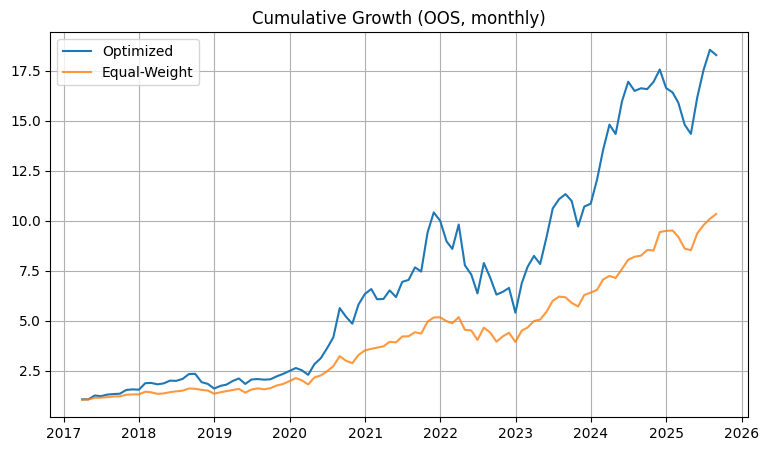

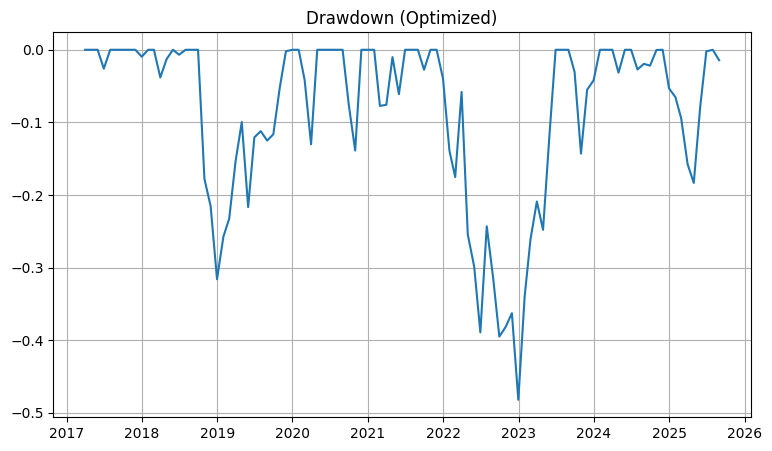

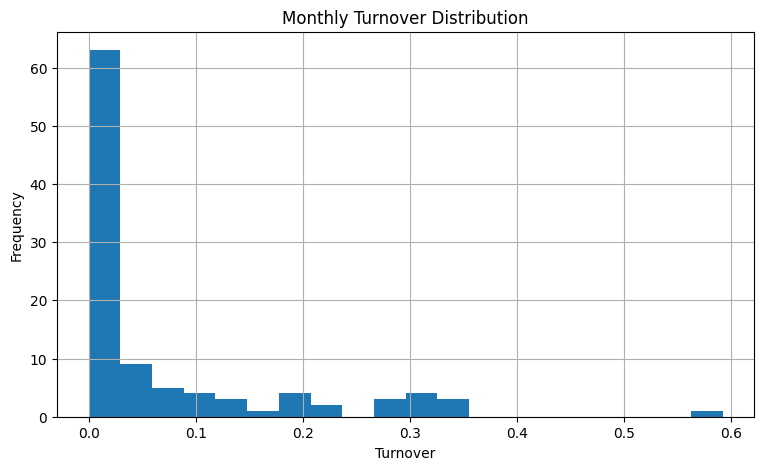

In [9]:
cum_opt = (1 + pnl).cumprod()
cum_ew  = (1 + ew_ret.loc[pnl.index]).cumprod()

plt.plot(cum_opt, label="Optimized")
plt.plot(cum_ew, label="Equal-Weight", alpha=0.8)
plt.title("Cumulative Growth (OOS, monthly)")
plt.legend(); plt.grid(True)
plt.savefig(FIG_DIR / "cum_growth_oos.png", bbox_inches="tight")
plt.show()

# Drawdown
def drawdown_curve(r):
    cum = (1 + r).cumprod()
    rollmax = cum.cummax()
    return cum/rollmax - 1

dd = drawdown_curve(pnl)
plt.plot(dd)
plt.title("Drawdown (Optimized)")
plt.grid(True)
plt.savefig(FIG_DIR / "drawdown_optimized.png", bbox_inches="tight")
plt.show()

# Turnover (distribution)
turnover.plot(kind="hist", bins=20)
plt.title("Monthly Turnover Distribution")
plt.xlabel("Turnover"); plt.grid(True)
plt.savefig(FIG_DIR / "turnover_hist.png", bbox_inches="tight")
plt.show()


In [10]:
(weights.tail(12)).to_csv(DATA_DIR / "weights_last_12m.csv")
summary_df.to_csv(DATA_DIR / "performance_summary.csv")

print("Saved:")
print((DATA_DIR / "weights_last_12m.csv").resolve())
print((DATA_DIR / "performance_summary.csv").resolve())


Saved:
C:\Users\tqtoa\finance-portfolio-optimization\notebooks\data\weights_last_12m.csv
C:\Users\tqtoa\finance-portfolio-optimization\notebooks\data\performance_summary.csv
